In [2]:
import os
import shap
import pickle
import openai
import warnings
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import missingno as msno

from statsmodels.nonparametric.smoothers_lowess import lowess
from xgboost import XGBRegressor, XGBClassifier
from plotly.colors import n_colors
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from scipy.stats import kruskal, shapiro, spearmanr, kendalltau


/Users/jimmy/Documents/GitHub/Asset-Management-Topic-Modeling/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# The significance level is the probability of rejecting the null hypothesis when it is true.
alpha = 0.05

lastest_date = '2022-11-24'

random_state = 42

warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None, "display.max_columns",
              None, 'display.max_colwidth', None)

os.environ["TOKENIZERS_PARALLELISM"] = "true"

openai.api_key = os.getenv('OPENAI_API_KEY')

In [4]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """
    return np.isnan(y), lambda z: np.nonzero(z)[0]

def extrainterpolate_nans_1d(y):
    nans, x = nan_helper(y)
    y[nans] = np.interp(x(nans), x(~nans), y[~nans])
    return y

In [5]:
path_dataset = os.path.join(os.path.dirname(os.getcwd()), 'Dataset')

path_result = os.path.join(os.path.dirname(os.getcwd()), 'Result')
if not os.path.exists(path_result):
    os.makedirs(path_result)

path_general = os.path.join(path_result, 'General')
if not os.path.exists(path_general):
    os.makedirs(path_general)

path_challenge = os.path.join(path_result, 'Challenge')
if not os.path.exists(path_challenge):
    os.makedirs(path_challenge)

path_solution = os.path.join(path_result, 'Solution')
if not os.path.exists(path_solution):
    os.makedirs(path_solution)

path_challenge_prevalence = os.path.join(path_challenge, 'Prevalence')
if not os.path.exists(path_challenge_prevalence):
    os.makedirs(path_challenge_prevalence)

path_challenge_difficulty = os.path.join(path_challenge, 'Difficulty')
if not os.path.exists(path_challenge_difficulty):
    os.makedirs(path_challenge_difficulty)

path_challenge_evolution = os.path.join(path_challenge, 'Evolution')
if not os.path.exists(path_challenge_evolution):
    os.makedirs(path_challenge_evolution)

In [37]:
prompt_topic = '''You will be given a list of keywords for each topic, I want you to provide a description of each topic in a two-word phrase but guarantee that each description is exclusive to the other. Also, for each description, you need to attach short comments on what these keywords are talking about in general.
###\n'''

with open(os.path.join(path_challenge, 'Topic terms.pickle'), 'rb') as handle:
    topic_terms = pickle.load(handle)

topic_term_list = []
for index, topic in enumerate(topic_terms):
    terms = ', '.join([term[0] for term in topic])
    topic_term = f'Topic {index}: {terms}'
    topic_term_list.append(topic_term)

completion = openai.ChatCompletion.create(
    model="gpt-4-32k",
    messages=[{"role": "user", "content": prompt_topic +
               '\n'.join(topic_term_list) + '\n###\n'}],
    temperature=0,
    max_tokens=1500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    timeout=100,
    stream=False)

topic_challenge = completion.choices[0].message.content
print(topic_challenge)


Topic 0: Environment Setup - Setting up software environments for development and execution
Topic 1: Pipeline Automation - Automating the execution of data processing pipelines
Topic 2: Docker - Containerization platform for building, shipping, and running applications
Topic 3: Hyperparameter Tuning - Optimizing model performance by tuning hyperparameters
Topic 4: Git Version Control - Tracking changes to code and collaborating with others
Topic 5: GPU Acceleration - Using graphics processing units to speed up machine learning tasks
Topic 6: Artifact Management - Managing and storing artifacts such as models, datasets, and code
Topic 7: Model Deployment - Deploying machine learning models for use in production environments
Topic 8: Data Labeling - Assigning labels to data for use in supervised learning tasks
Topic 9: Data Visualization - Creating visual representations of data for analysis and communication
Topic 10: Logging Metrics - Recording and tracking performance metrics during m

In [4]:
topic_mapping_challenge = {
    0: ('Package Management', 'Installing and configuring software packages and dependencies'),
    1: ('Pipeline Configuration', 'Automating the execution of data processing pipelines'),
    2: ('Docker Configuration', 'Containerization platform for building, shipping, and running applications'),
    3: ('Hyperparameter Tuning', 'Optimizing model performance by tuning hyperparameters'),
    4: ('Code Versioning', 'Managing and tracking changes in a repository using Git'),
    5: ('GPU Configuration', 'Using graphics processing units to speed up machine learning tasks'),
    6: ('Artifact Management', 'Uploading, downloading, and storing artifacts'),
    7: ('Endpoint Deployment', 'Deploying machine learning models for use in production environments'),
    8: ('Data Labeling', 'Assigning labels to data for use in supervised learning tasks'),
    9: ('Data Visualization', 'Creating visual representations of data for analysis and communication'),
    10: ('Metrics Logging', 'Recording and tracking performance metrics during model training and evaluation'),
    11: ('Account Management', 'Managing user accounts and access to resources'),
    12: ('Apache Spark Configuration', 'Installing and configuring Apache Spark distributed computing system for big data processing'),
    13: ('TensorFlow Configuration', 'Installing and configuring the TensorFlow machine learning framework'),
    14: ('Text Processing', 'Analyzing and manipulating text data'),
    15: ('Pandas Dataframe', 'Manipulating and analyzing tabular data using the Pandas library'),
    16: ('Model Exporting', 'Saving and exporting trained machine learning models'),
    17: ('Role-based Access Control', 'Controlling access to resources based on user roles and permissions'),
    18: ('Batch Processing', 'Processing large amounts of data in batches'),
    19: ('Model Registry', 'Registering, managing, and versioning models'),
    20: ('Database Connectivity', 'Connecting to and interacting with databases'),
    21: ('Resource Quota Control', 'Setting and managing limits on resource usage'),
    22: ('API Invocation', 'Calling APIs to perform tasks or retrieve data'),
    23: ('Forecasting', 'Using automated machine learning to generate forecasts'),
    24: ('Columnar Manipulation', 'Working with and manipulating columns in datasets'),
    25: ('Object Detection', 'Using machine learning to analyze and interpret visual data'),
    26: ('Web Service', 'Deploying machine learning models as web services'),
    27: ('Kubernetes Orchestration', 'Open-source container orchestration platform for managing containerized applications'),
    28: ('Tree-based Model', 'Building, training, and cutting tree-like structure to make predictions'),
    29: ('CSV Manipulation', 'Reading, writing, and manipulating CSV files'),
    30: ('TensorBoard Logging', 'Visualizing and tracking model training and evaluation using TensorBoard'),
    31: ('Feature Roadmap', 'Planning and implementing new features for a platform or product'),
    32: ('Dataset Versioning', 'Managing and versioning datasets'),
    33: ('CloudWatch Monitoring', 'Monitoring and logging AWS resources and applications'),
    34: ('Speech-to-Text', 'Converting audio speech to text'),
    35: ('YAML Configuration', 'Configuring and defining stages in a pipeline using YAML files'),
    36: ('Data Storage', 'Storing and accessing data in cloud-based storage solutions'),
    37: ('VPC Neworking', 'Connecting to AWS services privately through a VPC'),
    38: ('Model Evaluation', 'Evaluating and improving the accuracy of machine learning models'),
    39: ('Model Serving', 'Preparing and querying input data for machine learning models'),
    40: ('Bucket Access Control', 'Managing access to cloud-based storage buckets'),
    41: ('Run Management', 'Managing and monitoring the execution of jobs and tasks'),
    42: ('Model Inference', 'Using trained machine learning models to make predictions'),
    43: ('Jupyter Notebook', 'Creating and running interactive notebooks for data analysis and visualization'),
}


In [ ]:
prompt_topic = '''You will be given a list of keywords for each topic, I want you to provide a description of each topic in a two-word phrase but guarantee that each description is exclusive to the other. Also, for each description, you need to attach short comments on what these keywords are talking about in general.
###\n'''

with open(os.path.join(path_solution, 'Topic terms.pickle'), 'rb') as handle:
    topic_terms = pickle.load(handle)

topic_term_list = []
for index, topic in enumerate(topic_terms):
    terms = ', '.join([term[0] for term in topic])
    topic_term = f'Topic {index}: {terms}'
    topic_term_list.append(topic_term)

completion = openai.ChatCompletion.create(
    model="gpt-4-32k",
    messages=[{"role": "user", "content": prompt_topic +
               '\n'.join(topic_term_list) + '\n###\n'}],
    temperature=0,
    max_tokens=1500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    timeout=100,
    stream=False)

topic_solution = completion.choices[0].message.content
print(topic_solution)


Topic 0: Git Tracking - Managing and tracking changes in a repository using Git.
Topic 1: Access Control - Managing user roles and permissions for accessing resources.
Topic 2: Environment Setup - Installing and configuring software packages and dependencies.
Topic 3: Logging Metrics - Capturing and analyzing data related to system performance and behavior.
Topic 4: Dataset Management - Organizing and manipulating data for use in machine learning models.
Topic 5: Docker Deployment - Packaging and deploying applications in containers using Docker.
Topic 6: Parameter Configuration - Setting and adjusting parameters for software programs.
Topic 7: YAML Configuration - Configuring and defining stages in a pipeline using YAML files.
Topic 8: Endpoint Deployment - Deploying and managing endpoints for accessing APIs and web services.
Topic 9: Jupyter Notebooks - Creating and running interactive notebooks for data analysis and visualization.
Topic 10: Pandas Dataframes - Manipulating and analy

In [5]:
topic_mapping_solution = {
    0: ('Code Versioning', 'Managing and tracking changes in a repository using Git'),
    1: ('Role-based Access Control', 'Controlling access to resources based on user roles and permissions'),
    2: ('Package Management', 'Installing and configuring software packages and dependencies'),
    3: ('Metrics Logging', 'Recording and tracking performance metrics during model training and evaluation'),
    4: ('Columnar Manipulation', 'Working with and manipulating columns in datasets'),
    5: ('Docker Configuration', 'Containerization platform for building, shipping, and running applications'),
    6: ('Hyperparameter Tuning', 'Optimizing model performance by tuning hyperparameters'),
    7: ('YAML Configuration', 'Configuring and defining stages in a pipeline using YAML files'),
    8: ('Endpoint Serving', 'Creating, deploying, and managing endpoints for REST and web services'),
    9: ('Jupyter Notebook', 'Creating and running interactive notebooks for data analysis and visualization'),
    10: ('Pandas Dataframe', 'Manipulating and analyzing tabular data using the Pandas library'),
    11: ('TensorFlow Configuration', 'Installing and configuring the TensorFlow machine learning framework'),
    12: ('Artifact Management', 'Uploading, downloading, and storing artifacts'),
    13: ('Endpoint Deployment', 'Deploying machine learning models for use in production environments'),
    14: ('Tree-based Model', 'Building, training, and cutting tree-like structure to make predictions'),
    15: ('Pipeline Configuration (Model)', 'Building, inputting, and parameterizing pipelines for API and object use'),
    16: ('JSON Payload', 'Formatting, serializing, and loading data'),
    17: ('Remote Configuration', 'Adding, modifying, and running remote URLs and resources'),
    18: ('Apache Spark Configuration', 'Installing and configuring Apache Spark distributed computing system for big data processing'),
    19: ('Model Wrapper', 'Using PyFunc and PythonModel interfaces, importing models, and loading models'),
    20: ('Data Transfer', 'Transferring data between cloud-based storage solutions'),
    21: ('Cluster Configuration', 'Running and managing distributed computing jobs'),
    22: ('Pipeline Configuration (Data)', 'Creating and managing data pipelines'),
    23: ('CSV Manipulation', 'Reading, writing, and manipulating CSV files'),
    24: ('Model Registry', 'Registering, managing, and versioning models'),
    25: ('Memory Management', 'Managing memory and distributing training for large datasets'),
    26: ('Model Application', 'Using neural networks for machine learning'),
    27: ('SDK Management', 'Managing SDK versions'),
    28: ('Serverless Serving', 'Invoking endpoints and APIs using Lambda functions and API gateways'),
}


In [ ]:
topic_ensemble = [
    'Account Management',  # account management and authentication
    # installing and configuring Apache Spark distributed computing system for big data processing
    'Apache Spark Configuration',
    'API Invocation',  # invoking APIs and endpoints for REST and web services
    'Artifact Management',  # uploading, downloading, and storing artifacts
    'Batch Processing',  # batch processing of data
    'Bucket Access Control',  # managing access to cloud-based storage buckets
    'CloudWatch Monitoring',  # monitoring and logging cloud resources and applications
    'Cluster Configuration',  # running and managing distributed computing jobs
    'Code Versioning',  # managing and tracking changes in a repository using Git
    'Columnar Manipulation',  # working with and manipulating columns in datasets
    'CSV Manipulation',  # reading, writing, and manipulating CSV files
    'Data Labeling',  # labeling data for machine learning
    'Data Storage',  # storing and accessing data in cloud-based storage solutions
    'Data Transfer',  # transferring data between cloud-based storage solutions
    'Data Visualization',  # visualizing data using charts and graphs
    'Database Connectivity',  # connecting to and querying databases
    'Dataset Versioning',  # versioning and managing datasets
    # containerization platform for building, shipping, and running applications
    'Docker Configuration',
    'GPU Configuration',  # configuring and using GPUs for training and inference
    'Hyperparameter Tuning',  # optimizing model performance by tuning hyperparameters
    'JSON Payload',  # formatting, serializing, and loading data
    # creating and running interactive notebooks for data analysis and visualization
    'Jupyter Notebook',
    'Kubernetes Orchestration',  # managing and orchestrating Kubernetes clusters
    'Memory Management',  # managing memory and distributing training for large datasets
    # recording and tracking performance metrics during model training and evaluation
    'Metrics Logging',
    'Model Evaluation',  # evaluating model performance
    'Model Exporting',  # exporting models for use in production environments
    'Model Inference',  # making predictions using trained models
    'Model Registry',  # registering, managing, and versioning models
    'Model Serving',  # serving models for use in production environments
    'Endpoint Serving',  # creating, deploying, and managing endpoints for REST and web services
    # deploying machine learning models for use in production environments
    'Endpoint Deployment',
    # invoking endpoints and APIs using Lambda functions and API gateways
    'Serverless Serving',
    'Pandas Dataframe',  # manipulating and analyzing tabular data using the Pandas library
    'Pipeline Configuration',  # creating and managing data pipelines
    'Pipeline Configuration (Data)',  # creating and managing data pipelines
    # building, inputting, and parameterizing pipelines for API and object use
    'Pipeline Configuration (Model)',
    'Package Management',  # installing and configuring software packages and dependencies
    'Remote Configuration',  # adding, modifying, and running remote URLs and resources
    'Resource Quota Control',  # controlling resource quotas and limits
    # controlling access to resources based on user roles and permissions
    'Role-based Access Control',
    'Run Management',  # managing and tracking runs
    'SDK Management',  # managing SDK configurations and versions
    'TensorBoard Logging',  # logging and visualizing TensorFlow metrics
    # installing and configuring the TensorFlow machine learning framework
    'TensorFlow Configuration',
    'VPC Networking',  # configuring and managing virtual private clouds
    'Web Service',  # creating and managing web services
    'YAML Configuration',  # configuring and defining stages in a pipeline using YAML files
]

macro_topic_ensemble_inverse = [
    # Code versioning refers to the practice of tracking changes to software code over time.
    {'Code Management': ['Code Versioning']},
    # These words are all related to data management and analysis. They refer to various tasks and techniques used to organize, manipulate, store, transfer, and analyze data.
    {'Data Management': ['Artifact Management', 'Columnar Manipulation', 'CSV Manipulation', 'Data Labeling', 'Data Storage',
                         'Data Transfer', 'Data Visualization', 'Database Connectivity', 'Dataset Versioning', 'Pandas Dataframe', 'Batch Processing']},
    # All of these words are related to the development and management of machine learning models.
    {'Model Management': ['Hyperparameter Tuning',
                          'Model Evaluation', 'Model Exporting', 'Model Registry']},
    # These words are all related to the management and optimization of data pipelines in software development.
    {'Lifecycle Management': ['Pipeline Configuration',
                              'Pipeline Configuration (Data)', 'Pipeline Configuration (Model)', 'Run Management', 'Kubernetes Orchestration']},
    # All of these words relate to the configuration and management of infrastructure aspects of computer systems and networks. Specifically, they involve setting up and optimizing different components such as processing power, memory, network connections, and software to ensure that they work together efficiently and effectively.
    {'Infrastructure Management': ['Apache Spark Configuration', 'Cluster Configuration', 'Docker Configuration', 'GPU Configuration', 'VPC Networking', 'Memory Management',
                                   'Remote Configuration', 'Resource Quota Control', 'TensorFlow Configuration', 'Jupyter Notebook', 'Package Management', 'SDK Management', 'YAML Configuration']},
    # All of these words are related to the deployment and management of machine learning models or web services.
    {'Deployment Management': ['Endpoint Serving', 'Endpoint Deployment', 'Model Serving', 'Model Inference',
                               'JSON Payload', 'Web Service', 'Serverless Serving', 'API Invocation']},
    # All of these words are related to monitoring and logging data in various systems.
    {'Report Management': ['CloudWatch Monitoring',
                           'Metrics Logging', 'TensorBoard Logging', 'Metrics Logging']},
    # All of these words are related to controlling access to information or resources in a system.
    {'Security Management': ['Account Management',
                             'Bucket Access Control', 'Role-based Access Control']},
]

macro_topic_ensemble = {}
for dictionary in macro_topic_ensemble_inverse:
    for key, values in dictionary.items():
        for inner_value in values:
            macro_topic_ensemble[inner_value] = key

macro_topic_to_index = {}
for index, topics in enumerate(macro_topic_ensemble_inverse):
    for topic in topics:
        macro_topic_to_index[topic] = index + 1

challenge_ensemble = [topic[0] for topic in topic_mapping_challenge.values()]
solution_ensemble = [topic[0] for topic in topic_mapping_solution.values()]

print(f'Total: {len(topic_ensemble)}')
print(
    f'Challenge: {len(set(challenge_ensemble).intersection(set(topic_ensemble)))}')
print(
    f'Challenge: {set(challenge_ensemble).intersection(set(topic_ensemble))}')
print(
    f'Solution: {len(set(solution_ensemble).intersection(set(topic_ensemble)))}')
print(f'Solution: {set(solution_ensemble).intersection(set(topic_ensemble))}')
print(f'Both: {set(solution_ensemble).intersection(set(challenge_ensemble)).intersection(set(topic_ensemble))}')

In [14]:
df = pd.read_json(os.path.join(path_general, 'original.json'))
# BigQuery Stack Overflow public dataset is updated until Nov 24, 2022, 1:39:22 PM UTC-5
min(df['Challenge_created_time']), max(df['Challenge_created_time'])


(Timestamp('2014-08-08 14:04:22.160000'),
 Timestamp('2023-02-22 01:36:03.995000'))

In [68]:
# assign human-readable & high-level topics to challenges & solutions

df_topics = pd.read_json(os.path.join(path_general, 'original.json'))
# remove challenges that were created after the public dataset was released
df_topics = df_topics[df_topics['Challenge_created_time'] < lastest_date]

for index, row in df_topics.iterrows():
    if row['Challenge_topic'] in topic_mapping_challenge and topic_mapping_challenge[row['Challenge_topic']][0] in topic_ensemble:
        topic = topic_mapping_challenge[row['Challenge_topic']][0]
        df_topics.at[index, 'Challenge_topic'] = topic
        df_topics.at[index,
                     'Challenge_topic_macro'] = macro_topic_ensemble[topic]
        if pd.isna(row['Challenge_comment_count']):
            df_topics.at[index, 'Challenge_comment_count'] = 0
    else:
        df_topics.drop(index, inplace=True)
        continue

    if row['Solution_topic'] in topic_mapping_solution and topic_mapping_solution[row['Solution_topic']][0] in topic_ensemble:
        topic = topic_mapping_solution[row['Solution_topic']][0]
        df_topics.at[index, 'Solution_topic'] = topic
        df_topics.at[index,
                     'Solution_topic_macro'] = macro_topic_ensemble[topic]
    else:
        df_topics.at[index, 'Solution_topic'] = np.nan
        df_topics.at[index, 'Solution_topic_macro'] = np.nan

df_topics.to_json(os.path.join(path_general, 'filtered.json'),
                  indent=4, orient='records')


In [31]:
df = pd.read_json(os.path.join(path_general, 'filtered.json'))

df_topics = []
total_count = len(df)

for name, group in df.groupby('Challenge_topic_macro'):
    topic_info = {
        'Challenge topic': name,
        'Challenge count': group['Challenge_topic_macro'].count(),
        'Challenge proportion': group['Challenge_topic_macro'].count() / total_count * 100,
        'Challenge solved rate': group['Challenge_closed_time'].notna().sum() / group['Challenge_topic_macro'].count() * 100,
        'Challenge mean score': group['Challenge_score'].mean(),
        'Challenge mean favorite count': group['Challenge_favorite_count'].mean(),
        'Challenge mean link count': group['Challenge_link_count'].mean(),
        'Challenge mean information entropy': group['Challenge_information_entropy'].mean(),
        'Challenge mean readability': group['Challenge_readability'].mean(),
        'Challenge mean sentence count': group['Challenge_sentence_count'].mean(),
        'Challenge mean word count': group['Challenge_word_count'].mean(),
        'Challenge mean unique word count': group['Challenge_unique_word_count'].mean(),
        'Challenge mean view count': group['Challenge_view_count'].mean(),
        'Challenge mean answer count': group['Challenge_answer_count'].mean(),
        'Challenge mean comment count': group['Challenge_comment_count'].mean(),
        'Challenge mean participation count': group['Challenge_participation_count'].mean(),

        'Solution mean score': group['Solution_score'].mean(),
        'Solution mean link count': group['Solution_link_count'].mean(),
        'Solution mean information entropy': group['Solution_information_entropy'].mean(),
        'Solution mean readability': group['Solution_readability'].mean(),
        'Solution mean sentence count': group['Solution_sentence_count'].mean(),
        'Solution mean word count': group['Solution_word_count'].mean(),
        'Solution mean unique word count': group['Solution_unique_word_count'].mean(),
        'Solution mean comment count': group['Solution_comment_count'].mean(),

        'Challenge mean solved time': group['Challenge_solved_time'].mean(),
        'Challenge median solved time': group['Challenge_solved_time'].median(),
        'Challenge mean adjusted solved time': group['Challenge_adjusted_solved_time'].mean(),
        'Challenge median adjusted solved time': group['Challenge_adjusted_solved_time'].median(),
    }
    df_topics.append(topic_info)

df_topics = pd.DataFrame(df_topics)
df_topics.to_json(os.path.join(path_challenge, 'general.json'),
                  indent=4, orient='records')
df_topics[['Challenge topic', 'Challenge count', 'Challenge proportion']]


,Challenge topic,Challenge count,Challenge proportion
0,Code Management,325,3.905311
1,Data Management,1781,21.401106
2,Deployment Management,1202,14.443643
3,Infrastructure Management,2058,24.729632
4,Lifecycle Management,920,11.055035
5,Model Management,1068,12.833453
6,Report Management,526,6.320596
7,Security Management,442,5.311223


In [22]:
# Create challenge topic count distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Count'] = 1

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_topic_distribution.png'))

In [23]:
# Create challenge favorite count distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Challenge_favorite_count'] = df_topics['Challenge_favorite_count'].map(
    lambda x: 1e-07 if x == 0 else x)

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Challenge_favorite_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Challenge_favorite_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_favorite_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_favorite_distribution.png'))
fig.show()

In [24]:
# Create challenge view count distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Challenge_view_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Challenge_view_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_view_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_view_distribution.png'))
fig.show()

In [25]:
# Create challenge score distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Challenge_score'] = df_topics['Challenge_score'].map(
    lambda x: 1e-07 if x == 0 else x)

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Challenge_score',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Challenge_score',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_score',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_score_distribution.png'))
fig.show()

In [26]:
# Create challenge answer count distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Challenge_answer_count'] = df_topics['Challenge_answer_count'].map(
    lambda x: 1e-07 if x == 0 else x)

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Challenge_answer_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Challenge_answer_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_answer_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_answer_distribution.png'))
fig.show()

In [27]:
# Create challenge comment count distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Challenge_comment_count'] = df_topics['Challenge_comment_count'].map(
    lambda x: 1e-07 if x == 0 else x)

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Challenge_comment_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Challenge_comment_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_comment_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_comment_distribution.png'))
fig.show()

In [28]:
# Create challenge topic participation distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Challenge_participation_count'] = df_topics['Challenge_participation_count'].map(
    lambda x: 1e-07 if x == 0 else x)

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Tool', 'Platform', 'Solved'],
    values='Challenge_participation_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Platform', 'Solved', 'Tool'],
    values='Challenge_participation_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show()

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_participation_count',
    color='Challenge_topic_macro',
    color_continuous_scale='RdBu',
    color_discrete_sequence=px.colors.qualitative.Pastel,
)
fig = fig.update_layout(
    width=1500,
    height=750,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(
    path_challenge_prevalence, 'Challenge_participation_distribution.png'))
fig.show()

In [9]:
df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics = df_topics[df_topics['Solution_topic_macro'].notna()]

categories = ['Challenge_topic_macro', 'Solution_topic_macro']
df_topics = df_topics.groupby(categories).count().reset_index(name='value')

# we only visualize strong connection
df_topics = df_topics[df_topics['value'] > 50]

newDf = pd.DataFrame()
for i in range(len(categories)-1):
    tempDf = df_topics[[categories[i], categories[i+1], 'value']]
    tempDf.columns = ['source', 'target', 'value']
    newDf = pd.concat([newDf, tempDf])
newDf = newDf.groupby(['source', 'target']).agg({'value': 'sum'}).reset_index()

label = list(np.unique(df_topics[categories].values))
source = newDf['source'].apply(lambda x: label.index(x))
target = newDf['target'].apply(lambda x: label.index(x))
value = newDf['value']

fig = go.Figure(
    go.Sankey(
        arrangement='snap',
        link=dict(arrowlen=15, source=source, target=target, value=value),
        node=dict(label=label, thickness=100, pad=30),
    ))
fig.update_layout(
    height=2000,
    width=1000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.write_image(os.path.join(path_challenge_prevalence,
                'Challenge solution sankey.png'))
fig.show()

In [25]:
# log scale all numerical values for better visualization of long-tailed distributions

df = pd.read_json(os.path.join(path_general, 'filtered.json'))

df['Challenge_answer_count'] = np.log(df['Challenge_answer_count'] + 1)
df['Challenge_comment_count'] = np.log(df['Challenge_comment_count'] + 1)
df['Challenge_participation_count'] = np.log(
    df['Challenge_participation_count'] + 1)
df['Challenge_favorite_count'] = np.log(df['Challenge_favorite_count'] + 1)
df['Challenge_link_count'] = np.log(df['Challenge_link_count'] + 1)
df['Challenge_readability'] = np.log(df['Challenge_readability'] + 1)
df['Challenge_score'] = np.log(df['Challenge_score'] + 1)
df['Challenge_view_count'] = np.log(df['Challenge_view_count'] + 1)
df['Challenge_information_entropy'] = np.log(
    df['Challenge_information_entropy'] + 1)
df['Challenge_sentence_count'] = np.log(df['Challenge_sentence_count'] + 1)
df['Challenge_unique_word_count'] = np.log(
    df['Challenge_unique_word_count'] + 1)
df['Challenge_word_count'] = np.log(df['Challenge_word_count'] + 1)
df['Solution_comment_count'] = np.log(df['Solution_comment_count'] + 1)
df['Solution_comment_count'] = np.log(df['Solution_comment_count'] + 1)
df['Solution_link_count'] = np.log(df['Solution_link_count'] + 1)
df['Solution_readability'] = np.log(df['Solution_readability'] + 1)
df['Solution_score'] = np.log(df['Solution_score'] + 1)
df['Solution_sentence_count'] = np.log(df['Solution_sentence_count'] + 1)
df['Solution_unique_word_count'] = np.log(df['Solution_unique_word_count'] + 1)
df['Solution_word_count'] = np.log(df['Solution_word_count'] + 1)
df['Challenge_solved_time'] = np.log(df['Challenge_solved_time'] + 1)
df['Challenge_adjusted_solved_time'] = np.log(
    df['Challenge_adjusted_solved_time'] + 1)

df.to_json(os.path.join(path_general, 'logscale.json'),
           indent=4, orient='records')


In [185]:
# conduct Kruskal–Wallis test to check if various metrics differ significantly across topics

df = pd.read_json(os.path.join(path_general, 'filtered.json'))
groups = df['Challenge_topic_macro'].unique()

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_answer_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge answer count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_comment_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge comment count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_participation_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge participation count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_favorite_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge favorite count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_link_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge link count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_readability'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge readability of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Challenge_score']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge score of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_information_entropy'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge information entropy of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_sentence_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge sentence count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_view_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge view count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_unique_word_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge unique word count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_word_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge word count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_solved_time'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge solved time of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_adjusted_solved_time'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the challenge adjusted solved time of one topic is significantly different from the others')

df = df[df['Solution_topic_macro'].notna()]
groups = df['Challenge_topic_macro'].unique()

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_comment_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution comment count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_information_entropy'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution information entropy of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Solution_link_count']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution link count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_readability'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution readability of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Solution_score']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution score of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_sentence_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution sentence count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_unique_word_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution unique word count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Solution_word_count']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print(f'p = {p:.2f}, indicating at least the solution word count of one topic is significantly different from the others')


p = 0.00, indicating at least the challenge answer count of one topic is significantly different from the others
p = 0.00, indicating at least the challenge comment count of one topic is significantly different from the others
p = 0.00, indicating at least the challenge participation count of one topic is significantly different from the others
p = 0.00, indicating at least the challenge link count of one topic is significantly different from the others
p = 0.00, indicating at least the challenge readability of one topic is significantly different from the others
p = 0.00, indicating at least the challenge information entropy of one topic is significantly different from the others
p = 0.00, indicating at least the challenge sentence count of one topic is significantly different from the others
p = 0.00, indicating at least the challenge unique word count of one topic is significantly different from the others
p = 0.00, indicating at least the challenge word count of one topic is signif

In [4]:
df = pd.read_json(os.path.join(path_challenge, 'general.json'))

# Plot median solved time against mean solved time for each topic using count ratio as size
fig = px.scatter(df, y="Challenge solved rate", x="Challenge median solved time",
                 color="Challenge topic", hover_name="Challenge topic", size="Challenge count", trendline="ols", trendline_scope="overall", trendline_color_override="black")
fig.show()
fig.update_layout(
    width=1500,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig.write_image(os.path.join(
    path_challenge_difficulty, 'Challenge solved rate vs median solved time.png'))

# Plot median solved time against mean solved time for each topic using count ratio as size
fig = px.scatter(df, y="Challenge median solved time", x="Challenge mean solved time",
                 color="Challenge topic", hover_name="Challenge topic", size="Challenge count", trendline="ols", trendline_scope="overall", trendline_color_override="black")
fig.show()
fig.update_layout(
    width=1500,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig.write_image(os.path.join(
    path_challenge_difficulty, 'Challenge median vs mean solved time.png'))


In [6]:
df = pd.read_json(os.path.join(path_challenge, 'general.json'))

print(df[['Challenge topic', 'Challenge solved rate', 'Challenge median solved time', 'Challenge mean solved time', 'Challenge median adjusted solved time', 'Challenge mean adjusted solved time',
      'Challenge mean link count', 'Challenge mean information entropy', 'Challenge mean readability', 'Challenge mean sentence count', 'Challenge mean word count', 'Challenge mean unique word count']].to_latex(index=False, float_format="{:.1f}".format))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
Challenge topic & Challenge solved rate & Challenge median solved time & Challenge mean solved time & Challenge median adjusted solved time & Challenge mean adjusted solved time & Challenge mean link count & Challenge mean information entropy & Challenge mean readability & Challenge mean sentence count & Challenge mean word count & Challenge mean unique word count \\
\midrule
Code Management & 23.4 & 14.3 & 275.1 & 14.8 & 242.1 & 0.8 & 5.9 & 6.7 & 30.5 & 283.2 & 108.2 \\
Data Management & 28.5 & 20.7 & 255.6 & 21.9 & 423.8 & 0.9 & 6.0 & 8.2 & 30.6 & 275.8 & 112.1 \\
Deployment Management & 31.0 & 23.7 & 332.2 & 24.8 & 509.2 & 0.9 & 6.1 & 9.6 & 33.4 & 316.0 & 121.7 \\
Infrastructure Management & 31.3 & 32.1 & 526.6 & 34.6 & 873.9 & 1.0 & 6.1 & 9.4 & 40.8 & 339.3 & 124.9 \\
Lifecycle Management & 30.1 & 25.2 & 297.6 & 28.1 & 491.4 & 0.8 & 6.0 & 9.4 & 31.0 & 289.9 & 112.3 \\
Model Management & 30.3 & 25.9 & 292.3 & 29.2 & 652.0 & 0.8 & 6.0 & 9.0 & 35

In [58]:
df = pd.read_json(os.path.join(path_general, 'filtered.json'))

solved_rate = []
mean_solved_time = []
median_solved_time = []
mean_adjusted_solved_time = []
median_adjusted_solved_time = []

for name, group in df.groupby('Challenge_topic'):
    solved_rate.append(
        group['Challenge_closed_time'].notna().sum() / len(group))
    mean_solved_time.append(group['Challenge_solved_time'].mean())
    median_solved_time.append(group['Challenge_solved_time'].median())
    median_adjusted_solved_time.append(
        group['Challenge_adjusted_solved_time'].mean())
    mean_adjusted_solved_time.append(
        group['Challenge_adjusted_solved_time'].median())

solved_rate = np.argsort(np.flip(np.argsort(solved_rate)))
mean_solved_time = np.argsort(np.argsort(mean_solved_time))
median_solved_time = np.argsort(np.argsort(median_solved_time))
median_adjusted_solved_time = np.argsort(
    np.argsort(median_adjusted_solved_time))
mean_adjusted_solved_time = np.argsort(np.argsort(mean_adjusted_solved_time))

_, p = spearmanr(median_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and median solved time (spearmanr)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and median solved time (spearmanr)')

_, p = kendalltau(median_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and median solved time (kendalltau)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and median solved time (kendalltau)')

_, p = spearmanr(mean_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and mean solved time (spearmanr)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and mean solved time (spearmanr)')

_, p = kendalltau(mean_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and mean solved time (kendalltau)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and mean solved time (kendalltau)')

_, p = spearmanr(mean_adjusted_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and mean adjusted solved time (spearmanr)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and mean adjusted solved time (spearmanr)')

_, p = kendalltau(mean_adjusted_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and mean adjusted solved time (kendalltau)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and mean adjusted solved time (kendalltau)')

_, p = spearmanr(median_adjusted_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and median adjusted solved time (spearmanr)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and median adjusted solved time (spearmanr)')

_, p = kendalltau(median_adjusted_solved_time, solved_rate)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between solved rate and median adjusted solved time (kendalltau)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between solved rate and median adjusted solved time (kendalltau)')

_, p = spearmanr(median_solved_time, mean_solved_time)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between median and mean solved time (spearmanr)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between median and mean solved time (spearmanr)')

_, p = kendalltau(median_solved_time, mean_solved_time)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between median and mean solved time (kendalltau)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between median and mean solved time (kendalltau)')

_, p = spearmanr(mean_adjusted_solved_time, median_adjusted_solved_time)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between median and mean adjusted solved time (spearmanr)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between median and mean adjusted solved time (spearmanr)')

_, p = kendalltau(mean_adjusted_solved_time, median_adjusted_solved_time)
if p < alpha:
    print(f'p = {p:.2f}, indicating a significant correlation between median and mean adjusted solved time (kendalltau)')
else:
    print(f'p = {p:.2f}, indicating no significant correlation between median and mean adjusted solved time (kendalltau)')

p = 0.82, indicating no significant correlation between solved rate and median solved time (spearmanr)
p = 0.88, indicating no significant correlation between solved rate and median solved time (kendalltau)
p = 0.35, indicating no significant correlation between solved rate and mean solved time (spearmanr)
p = 0.36, indicating no significant correlation between solved rate and mean solved time (kendalltau)
p = 0.72, indicating no significant correlation between solved rate and mean adjusted solved time (spearmanr)
p = 0.62, indicating no significant correlation between solved rate and mean adjusted solved time (kendalltau)
p = 0.74, indicating no significant correlation between solved rate and median adjusted solved time (spearmanr)
p = 0.73, indicating no significant correlation between solved rate and median adjusted solved time (kendalltau)
p = 0.00, indicating a significant correlation between median and mean solved time (spearmanr)
p = 0.00, indicating a significant correlation be

In [66]:
# perform the Shapiro-Wilk test for normality to check if various metrics are Gaussian distributed

df = pd.read_json(os.path.join(path_general, 'filtered.json'))

_, p = shapiro(df['Challenge_answer_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge answer count: {result}Gaussian')

_, p = shapiro(df['Challenge_comment_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge comment count: {result}Gaussian')

_, p = shapiro(df['Challenge_participation_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge participation count: {result}Gaussian')

_, p = shapiro(df['Challenge_favorite_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge favorite count: {result}Gaussian')

_, p = shapiro(df['Challenge_link_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge link count: {result}Gaussian')

_, p = shapiro(df['Challenge_readability'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge readability: {result}Gaussian')

_, p = shapiro(df['Challenge_score'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge score: {result}Gaussian')

_, p = shapiro(df['Challenge_view_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge view count: {result}Gaussian')

_, p = shapiro(df['Challenge_information_entropy'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge information entropy: {result}Gaussian')

_, p = shapiro(df['Challenge_sentence_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge sentence count: {result}Gaussian')

_, p = shapiro(df['Challenge_unique_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge unique word count: {result}Gaussian')

_, p = shapiro(df['Challenge_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge word count: {result}Gaussian')

_, p = shapiro(df['Solution_comment_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution comment count: {result}Gaussian')

_, p = shapiro(df['Solution_comment_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution information entropy: {result}Gaussian')

_, p = shapiro(df['Solution_link_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution link count: {result}Gaussian')

_, p = shapiro(df['Solution_readability'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution readability: {result}Gaussian')

_, p = shapiro(df['Solution_score'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution score: {result}Gaussian')

_, p = shapiro(df['Solution_sentence_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution sentence count: {result}Gaussian')

_, p = shapiro(df['Solution_unique_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution unique word count: {result}Gaussian')

_, p = shapiro(df['Solution_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution word count: {result}Gaussian')

_, p = shapiro(df['Challenge_solved_time'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge solved time: {result}Gaussian')

_, p = shapiro(df['Challenge_adjusted_solved_time'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge adjusted solved time: {result}Gaussian')


p = 0.00, indicating challenge answer count: non-Gaussian
p = 0.00, indicating challenge comment count: non-Gaussian
p = 0.00, indicating challenge participation count: non-Gaussian
p = 1.00, indicating challenge favorite count: Gaussian
p = 0.00, indicating challenge link count: non-Gaussian
p = 0.00, indicating challenge readability: non-Gaussian
p = 1.00, indicating challenge score: Gaussian
p = 1.00, indicating challenge view count: Gaussian
p = 0.00, indicating challenge information entropy: non-Gaussian
p = 0.00, indicating challenge sentence count: non-Gaussian
p = 0.00, indicating challenge unique word count: non-Gaussian
p = 0.00, indicating challenge word count: non-Gaussian
p = 1.00, indicating solution comment count: Gaussian
p = 1.00, indicating solution information entropy: Gaussian
p = 1.00, indicating solution link count: Gaussian
p = 1.00, indicating solution readability: Gaussian
p = 1.00, indicating solution score: Gaussian
p = 1.00, indicating solution sentence coun

In [68]:
# draw the violin plots for the challenge solved time

df = pd.read_json(os.path.join(path_general, 'logscale.json'))

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', df['Challenge_topic_macro'].nunique(), colortype='rgb')

fig_challenge_solved_time = go.Figure()

for name_group, color in zip(df.groupby('Challenge_topic_macro'), colors):
    name, group = name_group
    open = group[group['Challenge_closed_time'].isna()]
    closed = group[group['Challenge_closed_time'].notna()]

    fig_challenge_solved_time.add_trace(go.Violin(
        x=closed['Challenge_solved_time'], y=closed['Challenge_topic_macro'], line_color=color))
    
fig_challenge_solved_time.update_traces(
    orientation='h', meanline_visible=True, side='positive', width=3, points=False)
fig_challenge_solved_time.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    showlegend=False,
    xaxis_title='Challenge solved time (hours) (log scale)',
)
fig_challenge_solved_time.write_image(os.path.join(
    path_challenge_difficulty, 'Challenge_solved_time.png'))

Challenge_answer_count              0
Challenge_comment_count             0
Challenge_favorite_count         2195
Challenge_information_entropy       0
Challenge_link_count                0
Challenge_readability               0
Challenge_score                   191
Challenge_sentence_count            0
Challenge_unique_word_count         0
Challenge_view_count             1685
Challenge_word_count                0
Challenge_participation_count       0
dtype: int64

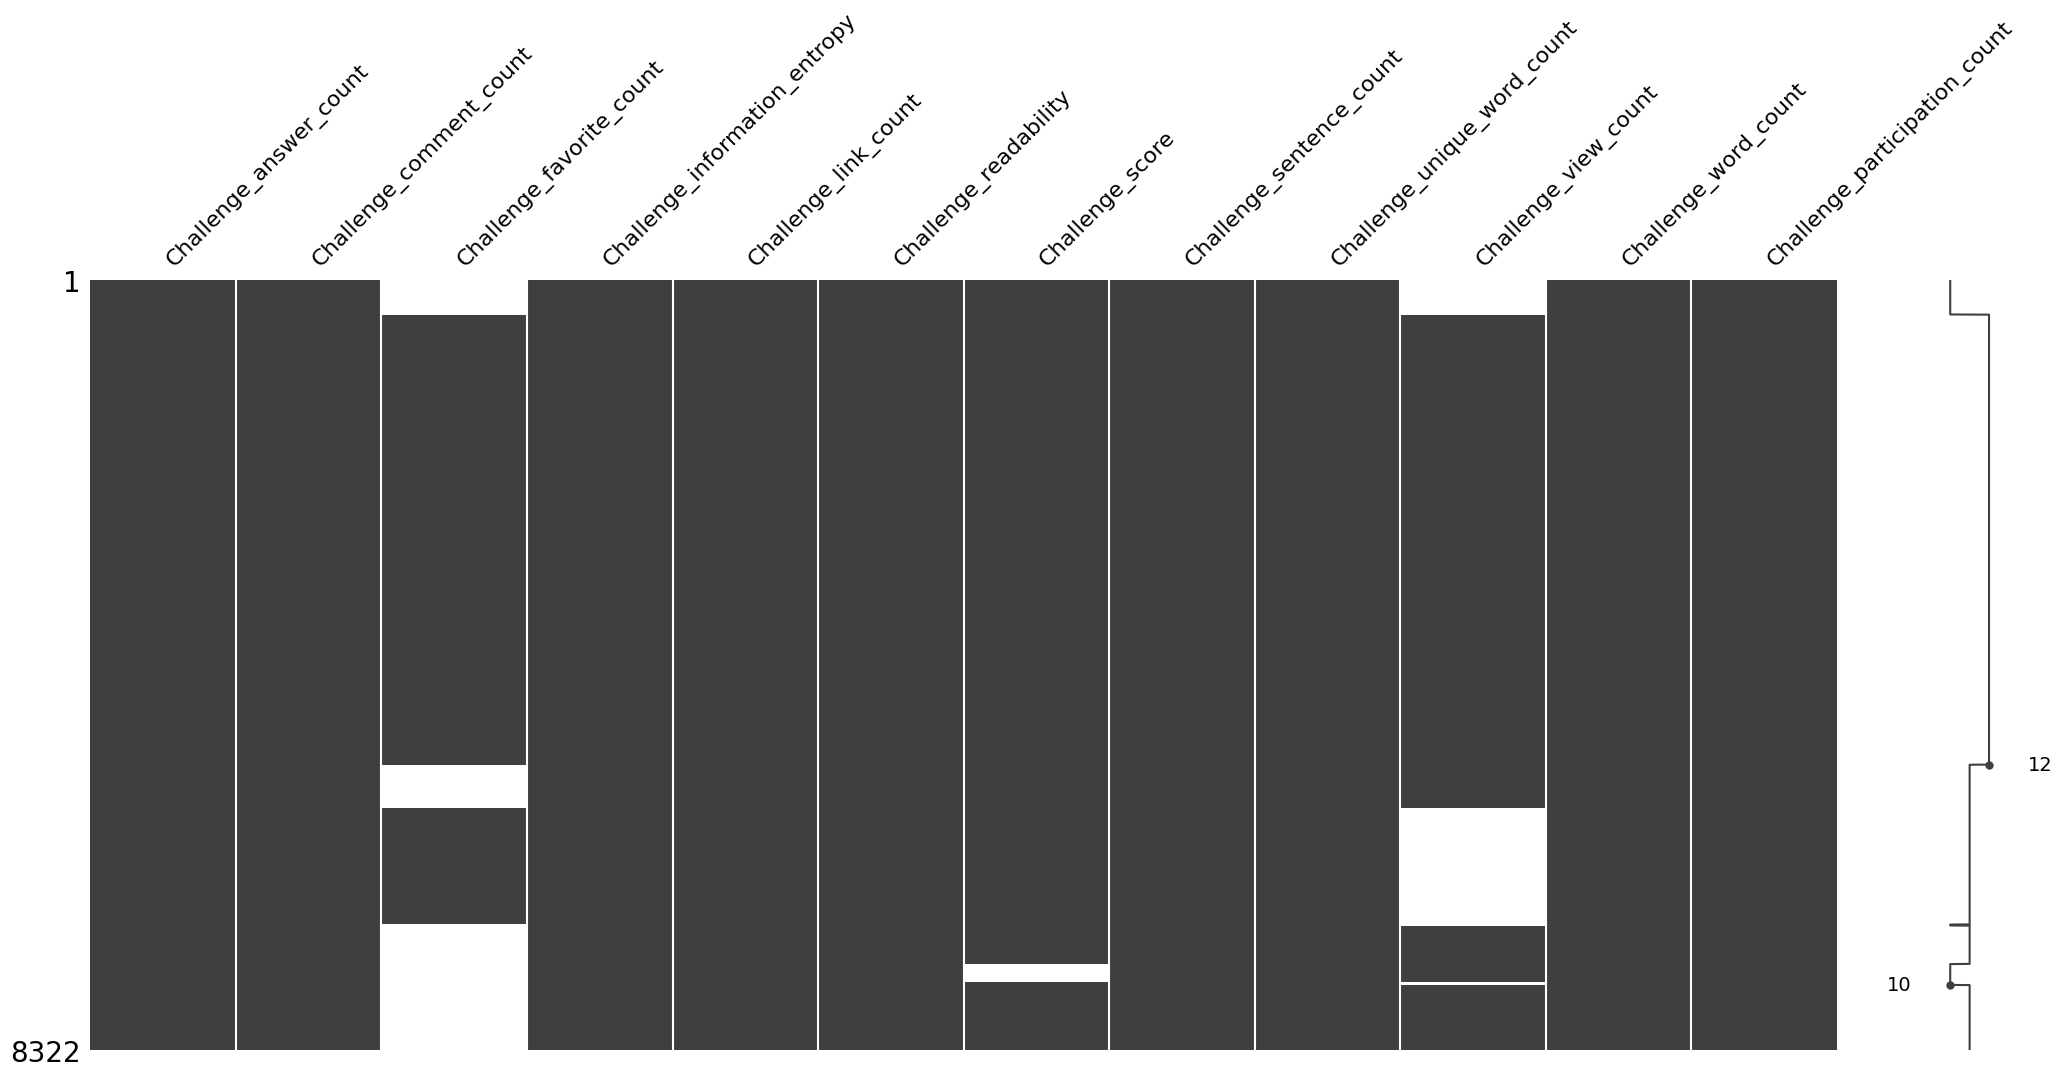

In [65]:
df = pd.read_json(os.path.join(path_general, 'filtered.json'))
df = df[df.columns.drop(
    list(df.filter(regex='Platform|Tool|Solution|solved_time|edit_time|topic')))]
df = df.drop(['Challenge_link', 'Challenge_closed_time',
             'Challenge_created_time'], axis=1)

ax = msno.matrix(df)
ax.figure.savefig(os.path.join(
    path_challenge_difficulty, 'Challenge missing values distribution.png'))
df.isna().sum()

In [40]:
import os
import wandb
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["WANDB__SERVICE_WAIT"] = "100"
os.environ['WANDB_SILENT'] = "true"

config_defaults = {
    'tree_method': 'gpu_hist',
    'n_estimators': 1000,
    'max_depth': 5,
    'cv': 5,
}

config_sweep = {
    "method": "bayes",
    "parameters": {
        'eta': {
            'min': 0.01, 'max': 0.3
        },
    },
}

count = 30
wandb_project = 'challenge-topic-difficulty-modeling'

In [49]:
class XGBClassification:
    def __init__(self):
        config_sweep['name'] = f'XGB Classifier'
        config_defaults['objective'] = 'binary:logistic'
        config_defaults['eval_metric'] = 'auc'
        config_sweep['metric'] = {'name': 'AUC', 'goal': 'maximize'}

        df = pd.read_json(os.path.join(path_general, 'filtered.json'))
        df = df[df.columns.drop(
            list(df.filter(regex='Platform|Tool|Solution|solved_time|edit_time|topic')))]

        self.y = df['Challenge_closed_time'].isna()
        self.X = df.drop(
            ['Challenge_link', 'Challenge_closed_time', 'Challenge_created_time'], axis=1)

    def __train(self):
        with wandb.init() as run:
            run.config.setdefaults(config_defaults)
            classifier = xgb.XGBClassifier(tree_method=run.config.tree_method, objective=run.config.objective, eval_metric=run.config.eval_metric,
                                           max_depth=run.config.max_depth, n_estimators=run.config.n_estimators, eta=wandb.config.eta)
            scores = cross_val_score(
                classifier, self.X, self.y, cv=run.config.cv)
            wandb.log({'AUC': scores.mean()})

    def sweep(self):
        wandb.login()
        sweep_id = wandb.sweep(config_sweep, project=wandb_project)
        wandb.agent(sweep_id, function=self.__train, count=count)

In [ ]:
# sweep for solved rate

classifier = XGBClassification()
classifier.sweep()


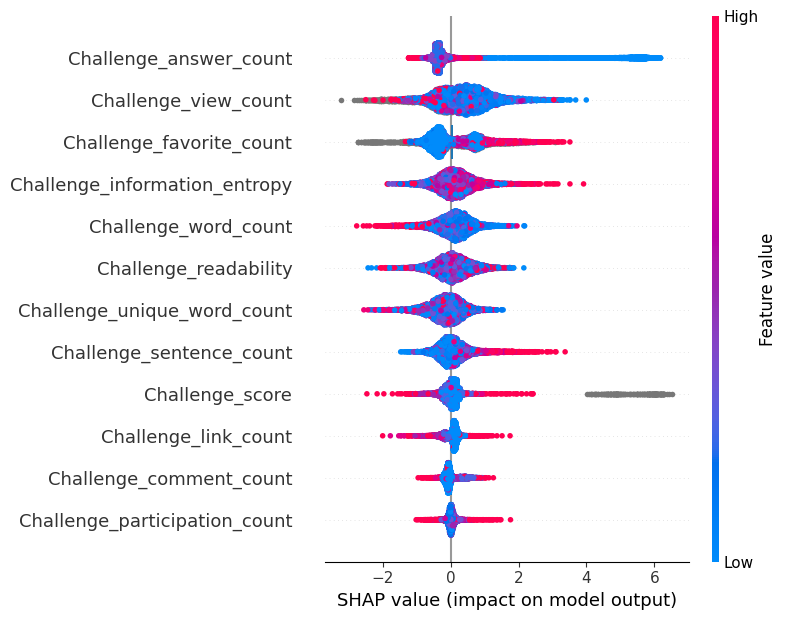

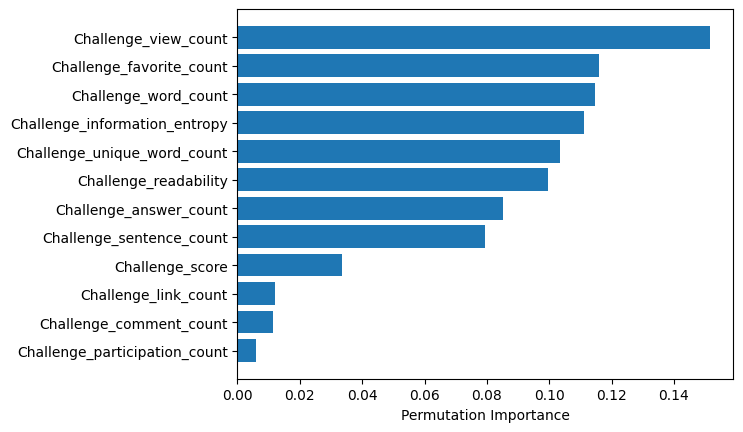

In [52]:
# check the explanability of the solved rate classification model

df = pd.read_json(os.path.join(path_general, 'filtered.json'))
df = df[df.columns.drop(
    list(df.filter(regex='Platform|Tool|Solution|solved_time|edit_time|topic')))]
y = df['Challenge_closed_time'].isna()
X = df.drop(['Challenge_link', 'Challenge_closed_time',
            'Challenge_created_time'], axis=1)

classifier = XGBClassifier(objective='binary:logistic', eval_metric='auc', tree_method='gpu_hist',
                           random_state=random_state, max_depth=5, n_estimators=1000, eta=0.1483)
classifier.fit(X, y)

sorted_idx = classifier.feature_importances_.argsort()
fig, _ = plt.subplots()
plt.barh(X.columns[sorted_idx][:10],
         classifier.feature_importances_[sorted_idx][:10])
plt.xlabel("Xgboost Feature Importance")
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_solved_rate xgboost_feature_importance.png'), bbox_inches='tight')

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, show=False)
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_solved_rate SHAP_based_feature_importance.png'), bbox_inches='tight')

perm_importance = permutation_importance(
    classifier, X, y, random_state=random_state)
sorted_idx = perm_importance.importances_mean.argsort()
fig, _ = plt.subplots()
plt.barh(X.columns[sorted_idx],
         perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_solved_rate permutation_based_feature_importance.png'), bbox_inches='tight')

In [34]:
# keep only solved challenges

df = pd.read_json(os.path.join(path_general, 'filtered.json'))
df = df[df['Solution_topic_macro'].notna()]
df.to_json(os.path.join(path_solution, 'solved.json'),
           indent=4, orient='records')


Challenge_answer_count             0
Challenge_comment_count            0
Challenge_favorite_count         735
Challenge_information_entropy      0
Challenge_link_count               0
Challenge_readability              0
Challenge_score                   81
Challenge_sentence_count           0
Challenge_unique_word_count        0
Challenge_view_count             406
Challenge_word_count               0
Solution_comment_count           735
Solution_information_entropy       0
Solution_link_count                0
Solution_readability               0
Solution_score                   516
Solution_sentence_count            0
Solution_unique_word_count         0
Solution_word_count                0
Challenge_participation_count      0
dtype: int64

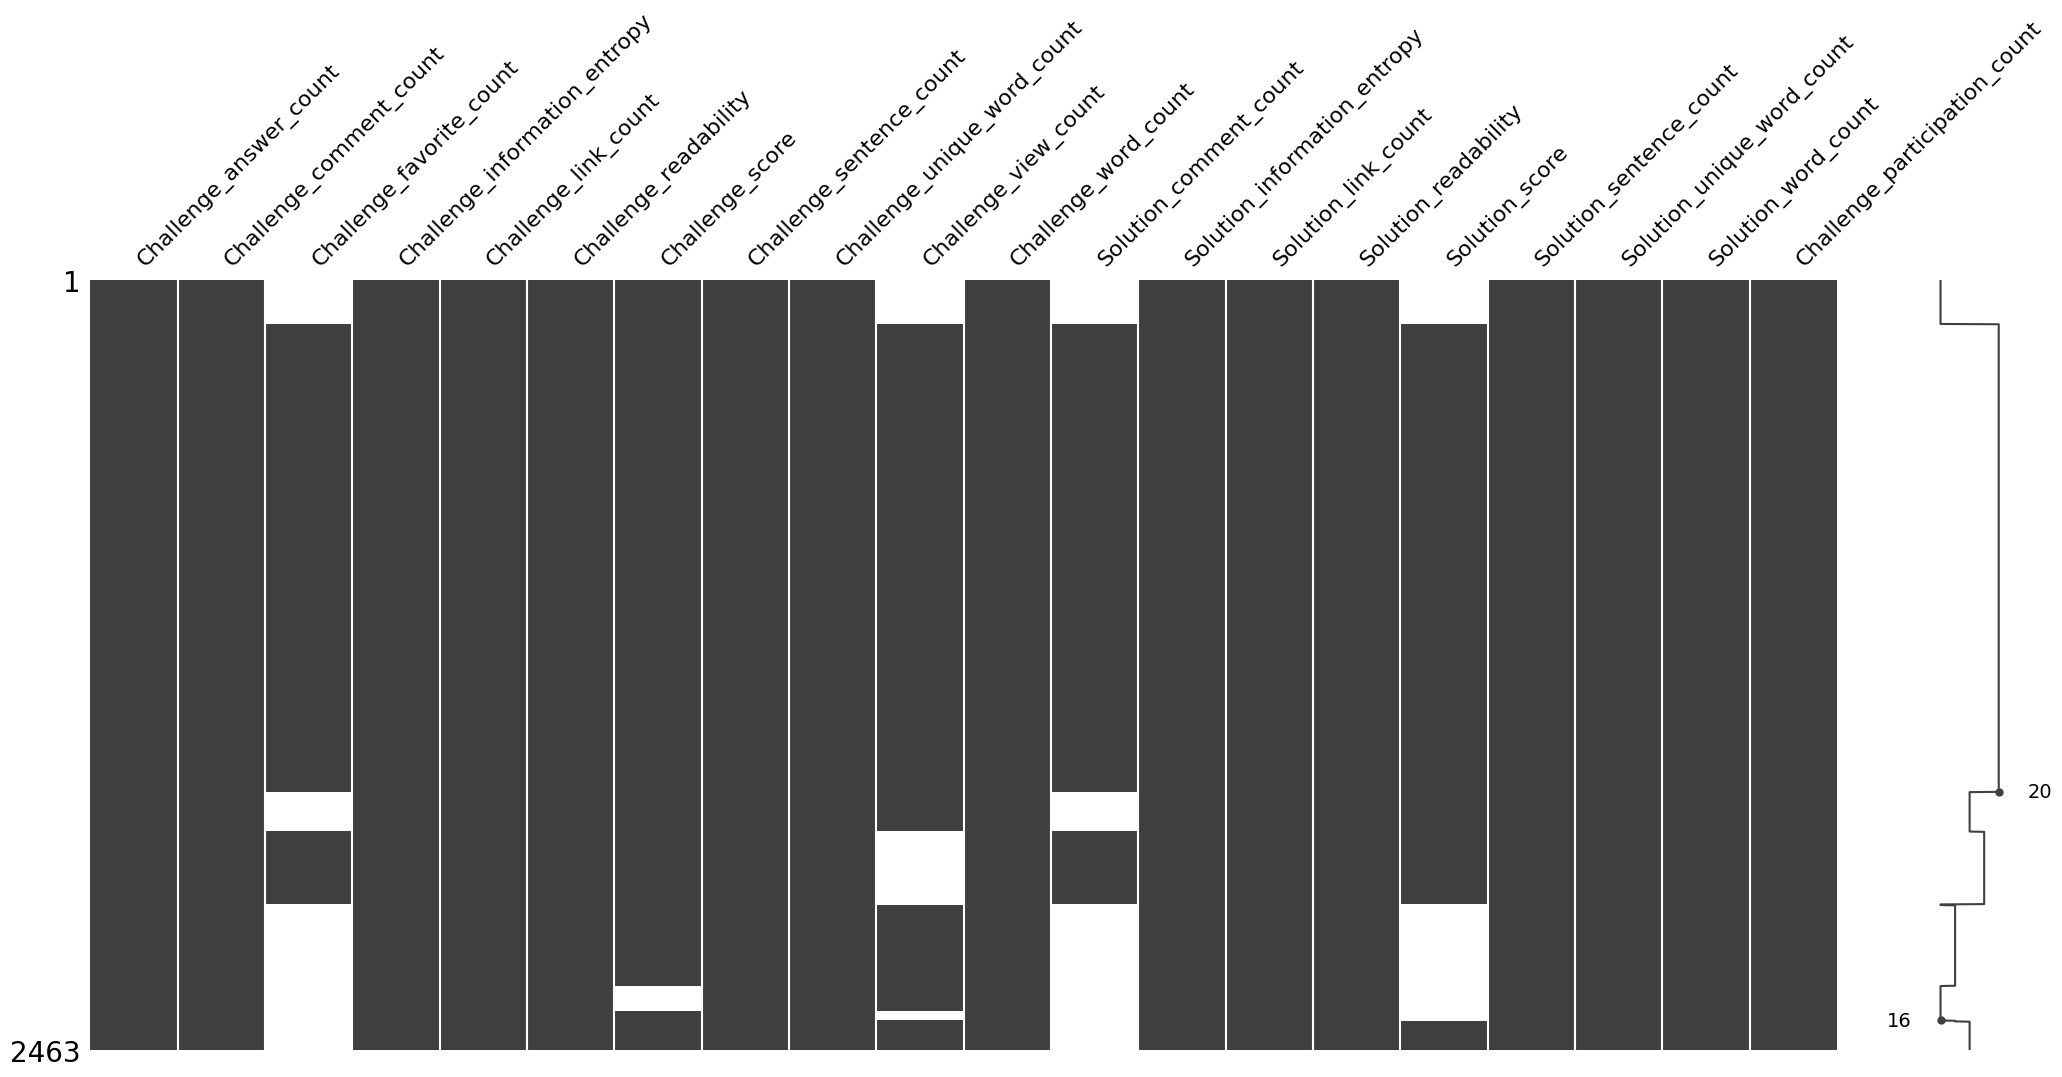

In [64]:
df_solved = pd.read_json(os.path.join(path_solution, 'solved.json'))
df_solved = df_solved[df_solved.columns.drop(
    list(df_solved.filter(regex='Platform|Tool|topic|solved_time|edit_time')))]
df_solved = df_solved.drop(
    ['Challenge_link', 'Challenge_closed_time', 'Challenge_created_time'], axis=1)

ax = msno.matrix(df_solved)
ax.figure.savefig(os.path.join(
    path_challenge_difficulty, 'Solution missing values distribution.png'))
df_solved.isna().sum()

In [45]:
class XGBRegression:
    def __init__(self, adjusted=False):
        config_defaults['objective'] = 'reg:squaredlogerror'
        config_sweep['metric'] = {'name': 'RMSLE', 'goal': 'maximize'}

        df = pd.read_json(os.path.join(path_solution, 'solved.json'))
        df = df.drop(['Challenge_link', 'Challenge_closed_time',
                     'Challenge_created_time'], axis=1)

        if adjusted:
            df = df[df['Challenge_adjusted_solved_time'].notna()]
            self.y = df['Challenge_adjusted_solved_time']
            config_sweep['name'] = f'XGB Regression: adjusted'
        else:
            df = df[df['Challenge_solved_time'].notna()]
            self.y = df['Challenge_solved_time']
            config_sweep['name'] = f'XGB Regression: original'

        self.X = df[df.columns.drop(
            list(df.filter(regex='Platform|Tool|topic|solved_time|edit_time')))]

    def __train(self):
        with wandb.init() as run:
            run.config.setdefaults(config_defaults)
            regressor = xgb.XGBRegressor(tree_method=run.config.tree_method, objective=run.config.objective,
                                         max_depth=run.config.max_depth, n_estimators=run.config.n_estimators, eta=wandb.config.eta)
            scores = cross_val_score(
                regressor, self.X, self.y, cv=run.config.cv)
            wandb.log({'RMSLE': scores.mean()})

    def sweep(self):
        wandb.login()
        sweep_id = wandb.sweep(config_sweep, project=wandb_project)
        wandb.agent(sweep_id, function=self.__train, count=count)

In [ ]:
# sweep for original solved time

regressor = XGBRegression()
regressor.sweep()


In [ ]:
# sweep for adjusted solved time

regressor = XGBRegression(True)
regressor.sweep()


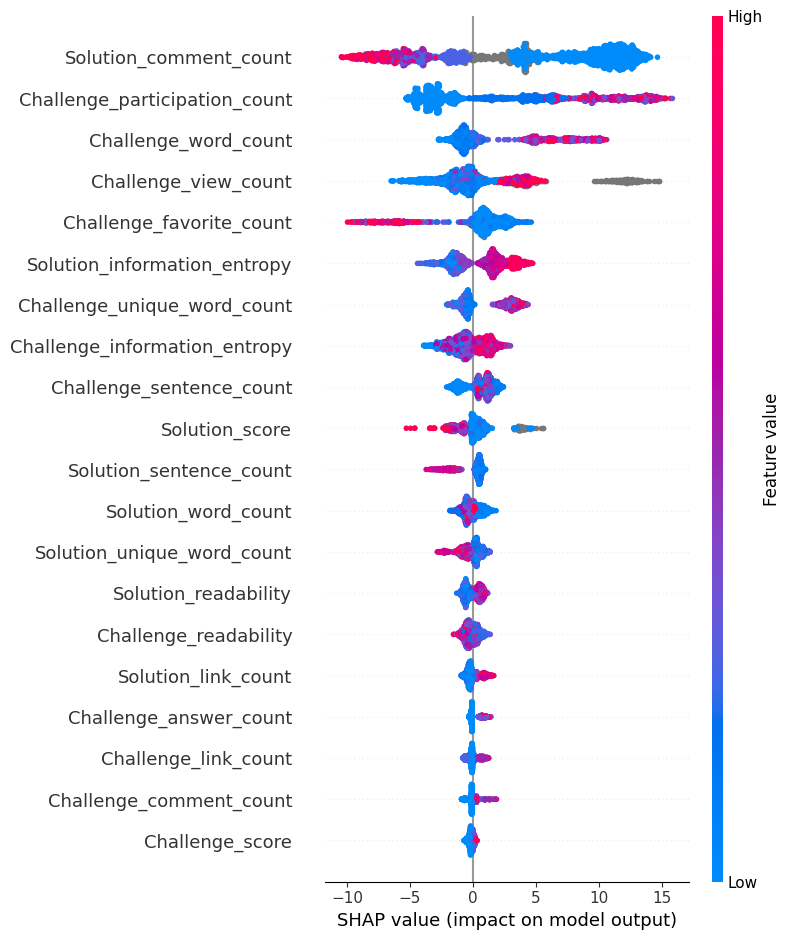

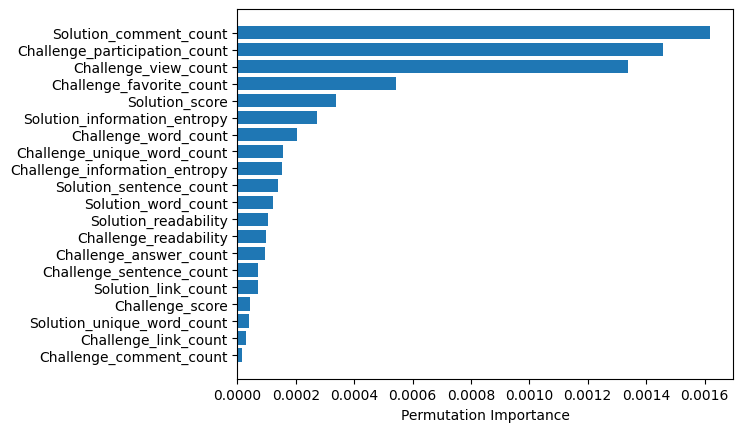

In [55]:
# check the explanability of the original solved time regression model

df_solved = pd.read_json(os.path.join(path_solution, 'solved.json'))
df_solved = df_solved[df_solved['Challenge_solved_time'].notna()]
df_solved = df_solved.drop(
    ['Challenge_link', 'Challenge_closed_time', 'Challenge_created_time'], axis=1)

y = df_solved['Challenge_solved_time']
X = df_solved[df_solved.columns.drop(
    list(df_solved.filter(regex='Platform|Tool|topic|solved_time|edit_time')))]

regressor = XGBRegressor(objective='reg:squaredlogerror', tree_method='gpu_hist',
                         random_state=random_state, max_depth=5, n_estimators=1000, eta=0.0206)
regressor.fit(X, y)

sorted_idx = regressor.feature_importances_.argsort()
fig, _ = plt.subplots()
plt.barh(X.columns[sorted_idx][:10],
         regressor.feature_importances_[sorted_idx][:10])
plt.xlabel("Xgboost Feature Importance")
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_solved_time xgboost_feature_importance.png'), bbox_inches='tight')

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, show=False)
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_solved_time SHAP_based_feature_importance.png'), bbox_inches='tight')

perm_importance = permutation_importance(
    regressor, X, y, random_state=random_state)
sorted_idx = perm_importance.importances_mean.argsort()
fig, _ = plt.subplots()
plt.barh(X.columns[sorted_idx],
         perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_solved_time permutation_based_feature_importance.png'), bbox_inches='tight')

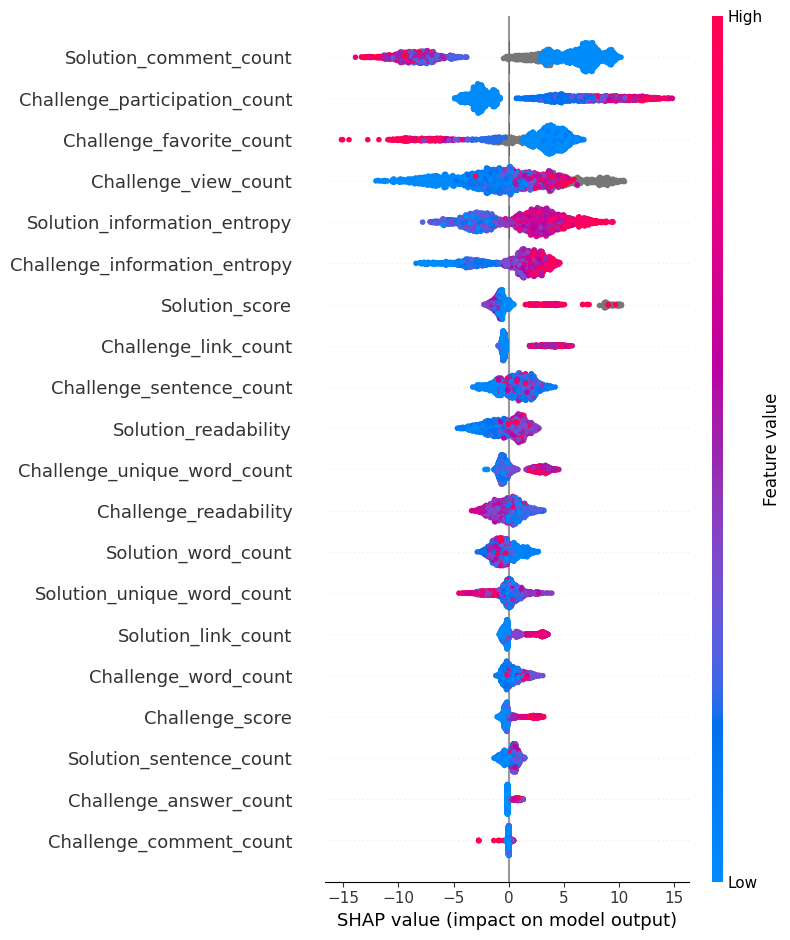

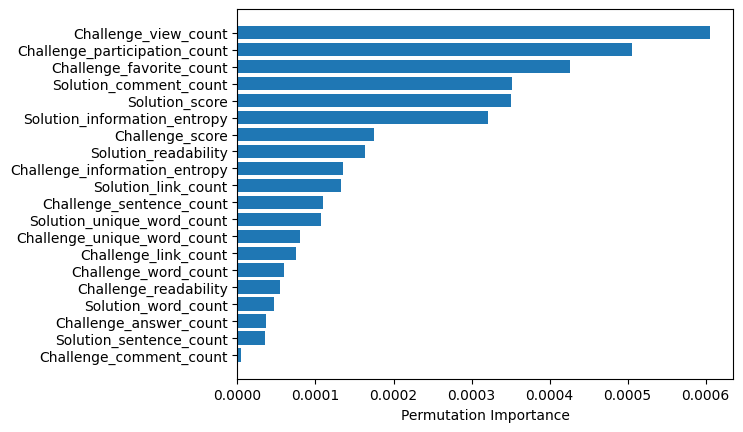

In [54]:
# check the explanability of the adjusted solved time regression model

df_solved = pd.read_json(os.path.join(path_solution, 'solved.json'))
df_solved = df_solved[df_solved['Challenge_adjusted_solved_time'].notna()]
df_solved = df_solved.drop(
    ['Challenge_link', 'Challenge_closed_time', 'Challenge_created_time'], axis=1)

y = df_solved['Challenge_adjusted_solved_time']
X = df_solved[df_solved.columns.drop(
    list(df_solved.filter(regex='Platform|Tool|topic|solved_time|edit_time')))]

regressor = XGBRegressor(objective='reg:squaredlogerror', tree_method='gpu_hist',
                         random_state=random_state, max_depth=5, n_estimators=1000, eta=0.03353)
regressor.fit(X, y)

sorted_idx = regressor.feature_importances_.argsort()
fig, _ = plt.subplots()
plt.barh(X.columns[sorted_idx],
         regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_adjusted_solved_time xgboost_feature_importance.png'), bbox_inches='tight')

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, show=False)
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_adjusted_solved_time SHAP_based_feature_importance.png'), bbox_inches='tight')

perm_importance = permutation_importance(
    regressor, X, y, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig, _ = plt.subplots()
plt.barh(X.columns[sorted_idx],
         perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig(os.path.join(path_challenge_difficulty,
            f'Challenge_adjusted_solved_time permutation_based_feature_importance.png'), bbox_inches='tight')

In [59]:
# plot the challenge mertics over time

df_challenge = pd.read_json(os.path.join(path_general, 'filtered.json'))

fig_challenge_topic_count = go.Figure()
fig_challenge_score = go.Figure()
fig_challenge_view_count = go.Figure()
fig_challenge_favorite_count = go.Figure()
fig_challenge_comment_count = go.Figure()
fig_challenge_answer_count = go.Figure()
fig_challenge_participation_count = go.Figure()
fig_challenge_word_count = go.Figure()
fig_challenge_unique_word_count = go.Figure()
fig_challenge_sentence_count = go.Figure()
fig_challenge_link_count = go.Figure()
fig_challenge_information_entropy = go.Figure()
fig_challenge_readability = go.Figure()
fig_challenge_topic_closed_count = go.Figure()
fig_challenge_solved_rate = go.Figure()

for name, group in df_challenge.groupby('Challenge_topic_macro'):
    # plot challenge topic count over time
    group_count = group.groupby(pd.Grouper(key='Challenge_created_time', freq='3M'))[
        'Challenge_topic_macro'].count().reset_index()
    group_count = group_count[group_count['Challenge_created_time'] < lastest_date]
    x = pd.to_datetime(group_count['Challenge_created_time']).values
    y = np.diff(group_count['Challenge_topic_macro'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_topic_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge participation count over time
    group_evolution = group.groupby(pd.Grouper(key='Challenge_created_time', freq='3M'))[
        ['Challenge_participation_count', 'Challenge_view_count', 'Challenge_favorite_count', 'Challenge_comment_count', 'Challenge_answer_count', 'Challenge_score', 'Challenge_word_count', 'Challenge_unique_word_count', 'Challenge_sentence_count', 'Challenge_link_count', 'Challenge_information_entropy', 'Challenge_readability']].sum().reset_index()
    group_evolution = group_evolution[group_evolution['Challenge_created_time'] < lastest_date]
    y = np.diff(group_evolution['Challenge_participation_count'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_participation_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge score over time
    y = np.diff(group_evolution['Challenge_score'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_score.add_trace(go.Scatter(
        x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge comment count over time
    y = np.diff(group_evolution['Challenge_comment_count'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_comment_count.add_trace(go.Scatter(
        x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge answer count over time
    y = np.diff(group_evolution['Challenge_answer_count'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_answer_count.add_trace(go.Scatter(
        x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge view count over time
    y = np.diff(group_evolution['Challenge_view_count'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_view_count.add_trace(go.Scatter(
        x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge favorite count over time
    y = np.diff(group_evolution['Challenge_favorite_count'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_favorite_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge link count over time
    y = group_evolution['Challenge_link_count'].values / \
        group_count['Challenge_topic_macro'].values
    y = extrainterpolate_nans_1d(y)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_link_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge sentence count over time
    y = group_evolution['Challenge_sentence_count'].values / \
        group_count['Challenge_topic_macro'].values
    y = extrainterpolate_nans_1d(y)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_sentence_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge word count over time
    y = group_evolution['Challenge_word_count'].values / \
        group_count['Challenge_topic_macro'].values
    y = extrainterpolate_nans_1d(y)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_word_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge unique word count over time
    y = group_evolution['Challenge_unique_word_count'].values / \
        group_count['Challenge_topic_macro'].values
    y = extrainterpolate_nans_1d(y)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_unique_word_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge information entropy over time
    y = group_evolution['Challenge_information_entropy'].values / \
        group_count['Challenge_topic_macro'].values
    y = extrainterpolate_nans_1d(y)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_information_entropy.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge readability over time
    y = group_evolution['Challenge_readability'].values / \
        group_count['Challenge_topic_macro'].values
    y = extrainterpolate_nans_1d(y)
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_readability.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge solved rate over time
    group_all = group.groupby(pd.Grouper(key='Challenge_created_time', freq='3M'))['Challenge_topic_macro'].count(
    ).cumsum().reset_index().rename(columns={'Challenge_created_time': 'Date', 'Challenge_topic_macro': 'All'})
    group_closed = group.groupby(pd.Grouper(key='Challenge_closed_time', freq='3M'))['Challenge_topic_macro'].count(
    ).cumsum().reset_index().rename(columns={'Challenge_closed_time': 'Date', 'Challenge_topic_macro': 'Solved'})
    group_solved = pd.merge(group_closed, group_all, on='Date', how='outer').fillna(0).sort_values(by='Date')
    group_solved = group_solved[group_solved['Date'] < lastest_date]
    x = pd.to_datetime(group_solved['Date']).values
    y = group_solved['Solved'] / group_solved['All'] * 100
    y = extrainterpolate_nans_1d(y)
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_solved_rate.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge closed topic count over time
    group_evolution = group.groupby(pd.Grouper(key='Challenge_closed_time', freq='3M'))[
        'Challenge_topic_macro'].count().reset_index()
    group_evolution = group_evolution[group_evolution['Challenge_closed_time'] < lastest_date]
    x = pd.to_datetime(group_evolution['Challenge_closed_time']).values
    y = np.diff(group_evolution['Challenge_topic_macro'].values)
    y = extrainterpolate_nans_1d(y)
    y = np.insert(y, 0, 0)
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_topic_closed_count.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

fig_challenge_topic_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_view_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_favorite_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_participation_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_score.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_answer_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_comment_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_topic_closed_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_solved_rate.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_word_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_unique_word_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_sentence_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_link_count.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_information_entropy.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_readability.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))

fig_challenge_topic_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_topic_count_increase_rate.png'))
fig_challenge_view_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_view_count_increase_rate.png'))
fig_challenge_favorite_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_favorite_count_increase_rate.png'))
fig_challenge_score.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_score_increase_rate.png'))
fig_challenge_answer_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_answer_count_increase_rate.png'))
fig_challenge_comment_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_comment_count_increase_rate.png'))
fig_challenge_participation_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_participation_count_increase_rate.png'))
fig_challenge_topic_closed_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_topic_closed_count_increase_rate.png'))
fig_challenge_solved_rate.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_solved_rate.png'))
fig_challenge_word_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_word_count.png'))
fig_challenge_unique_word_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_unique_word_count.png'))
fig_challenge_sentence_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_sentence_count.png'))
fig_challenge_link_count.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_link_count.png'))
fig_challenge_information_entropy.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_information_entropy.png'))
fig_challenge_readability.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_readability.png'))

In [62]:
# plot challenge mean & median solved time over time

df_challenge = pd.read_json(os.path.join(path_general, 'logscale.json'))

fig_challenge_mean_solved_time = go.Figure()
fig_challenge_median_solved_time = go.Figure()

for name, group in df_challenge.groupby('Challenge_topic_macro'):
    # plot challenge mean solved time over time
    group_evolution = group.groupby(pd.Grouper(key='Challenge_created_time', freq='Y'))[
        'Challenge_solved_time'].mean().reset_index()
    x = pd.to_datetime(group_evolution['Challenge_created_time']).values
    y = group_evolution['Challenge_solved_time'].values
    # y = extrainterpolate_nans_1d(y)
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_mean_solved_time.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

    # plot challenge median solved time over time
    group_evolution = group.groupby(pd.Grouper(key='Challenge_created_time', freq='Y'))[
        'Challenge_solved_time'].median().reset_index()
    y = group_evolution['Challenge_solved_time'].values
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    y_lowess = lowess(y, x_lowess, return_sorted=False)
    fig_challenge_median_solved_time.add_trace(
        go.Scatter(x=x, y=y_lowess, mode='lines', name=name))

fig_challenge_mean_solved_time.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_median_solved_time.update_layout(
    width=1000,
    height=750,
    margin=dict(l=0, r=0, t=0, b=0))

fig_challenge_mean_solved_time.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_mean_solved_time.png'))
fig_challenge_median_solved_time.write_image(os.path.join(
    path_challenge_evolution, f'Challenge_median_solved_time.png'))
